In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.interpolate import interp1d
from scipy.special import spherical_jn
from tqdm import tqdm

import mu2
from interaction import LocalSystem, potential
import constants as const
import utility
import bind

plt.style.use('science')
gr = 4/3
h = 3

In [2]:
def alpha(r):
    return 9/2 - 2/3*np.exp(-2*r) * (r**5 + 9/2*r**4 + 9*r**3 + 27/2*r**2 + 27/2*r + 27/4)


def mm_potential(r):
    return -1/2 * alpha(r) / r**4

In [3]:
# Compute the Mott-Massey results
Ri = 1.5
f = 20
nq = 520
qmax = f*10/Ri
qmesh = utility.log_mesh(0, qmax, nq)
mm = LocalSystem(1.5, qmesh=(*qmesh, qmax))
mm_vtilde = utility.ft_matrix_gen(mm_potential, 0, 0, mm.q, mm.r_nodes, mm.r_weights)
mm_evals, mm_evecs = bind.bound_states(mm_vtilde, 0, 0, mm.q, mm.wq)

In [4]:
KCD_0_MM = mu2.cc.cscatter.kcotdelta_py(0, mm_vtilde, mm.q, mm.wq, mm.q_max, 0, 2*const.MU)

In [85]:
def ftr(state, r, q, wq):
    y = np.array([np.sum(np.sqrt(2/np.pi) * wq * q**2 * state * spherical_jn(0, q*ri)) for ri in r])
    return 1/np.sqrt(np.sum(ls.r_weights * ls.r_nodes**2 * y**2)) * y


def local_LO_counterterm(r, R):
    return np.exp(-(r/R)**4)


def M_coord(ls, evals, evecs):
    overlap = np.zeros(7)
    for i in range(7):
        psi = np.abs(ftr(evecs[:, i], ls.r_nodes, ls.q, ls.wq)) # / ls.r_nodes
        overlap[i] = np.sum(ls.r_weights * ls.r_nodes**2 * local_LO_counterterm(ls.r_nodes, ls.r_c) * psi**2)
    return overlap


def normalization_constant(state, q, wq):
    C2 = np.sum(ls.wq * ls.q**2 * state**2)
    return np.sqrt(C2)


def M_mom(ls, evals, evecs):
    overlap = np.zeros(7)
    norm = np.array([
        normalization_constant(evecs[:, i], ls.q, ls.wq) for i in range(7)
    ])
    for i in range(7):
        x = ls.wq * ls.q**2 * norm[i] * evecs[:, i]
        overlap[i] = x @ (ls.counterterm.gen(1, 0) @ x)
    return overlap
    
def evals_and_evecs(g, ls):
    return bind.bound_states(ls.v_tilde, ls.counterterm.gen(g, 0), 1, ls.q, ls.wq)


def f_root(theta, ls, momentum_space=True):
    glo, gnlo = theta
    kcd_0 = mu2.cc.cscatter.kcotdelta_py(
        0, ls.v_tilde + ls.counterterm.gen(glo, 0), ls.q, ls.wq, ls.q_max, 0, 2*const.MU
    )
    evals, evecs = evals_and_evecs(glo, ls)
    evals = evals[np.where(np.abs(evals) > 1e-9)[0]]
    assert evals.size == 7, f'There are {evals.size} bounds states.'
    
#     overlap = psi_Vnlo_psi(evals, evecs, ls.r_c)
    overlap = M_mom(ls, evals, evecs)
    return np.array([
        (KCD_0_MM - kcd_0)/KCD_0_MM, (mm_evals[6] - evals[6]*(1 + gnlo*overlap[6])) / mm_evals[6]
    ])

In [86]:
Rs, gs = np.loadtxt('rgflow_local_lo_a0_fix_hp.txt', unpack=True)

In [93]:
index = 49
Ri = Rs[index]
gi = gs[index]
qmax = 22*2/Ri
qmesh = utility.log_mesh(0, qmax, 860)
rmesh = utility.log_mesh(0, 10*const.BETA4, 2000)
ls = LocalSystem(Ri, qmesh=(*qmesh, qmax), rmesh=rmesh)
evals, evecs = bind.bound_states(ls.v_tilde, ls.counterterm.gen(gi, 0), 1, ls.q, ls.wq)

In [94]:
M_coord(ls, evals, evecs)

array([2.01139110e-05, 1.09941356e-05, 7.27838952e-06, 4.67078342e-06,
       2.68028454e-06, 1.27252348e-06, 2.44986247e-07])

In [90]:
M_coord(ls, evals, evecs)

array([1.96377237e-05, 1.02712530e-05, 6.73161139e-06, 4.52469387e-06,
       2.58634321e-06, 1.25182673e-06, 2.44177240e-07])

In [88]:
M_coord(ls, evals, evecs)

array([1.94446305e-05, 1.03627112e-05, 6.88786615e-06, 4.58798178e-06,
       2.59537327e-06, 1.25274417e-06, 2.44203810e-07])

In [60]:
M_mom(ls, evals, evecs)

array([2.07582842e-09, 2.49760747e-09, 2.06468725e-10, 3.13373509e-11,
       1.57024054e-12, 3.09882263e-14, 3.72809675e-17])

In [58]:
M_mom(ls, evals, evecs)

array([2.17838513e-09, 2.62101780e-09, 2.16671564e-10, 3.28861722e-11,
       1.64786552e-12, 3.25207298e-14, 3.91266052e-17])

In [53]:
M_mom(ls, evals, evecs)

array([2.26083876e-09, 2.72054171e-09, 2.24924598e-10, 3.41425340e-11,
       1.71101706e-12, 3.37714080e-14, 4.06376744e-17])

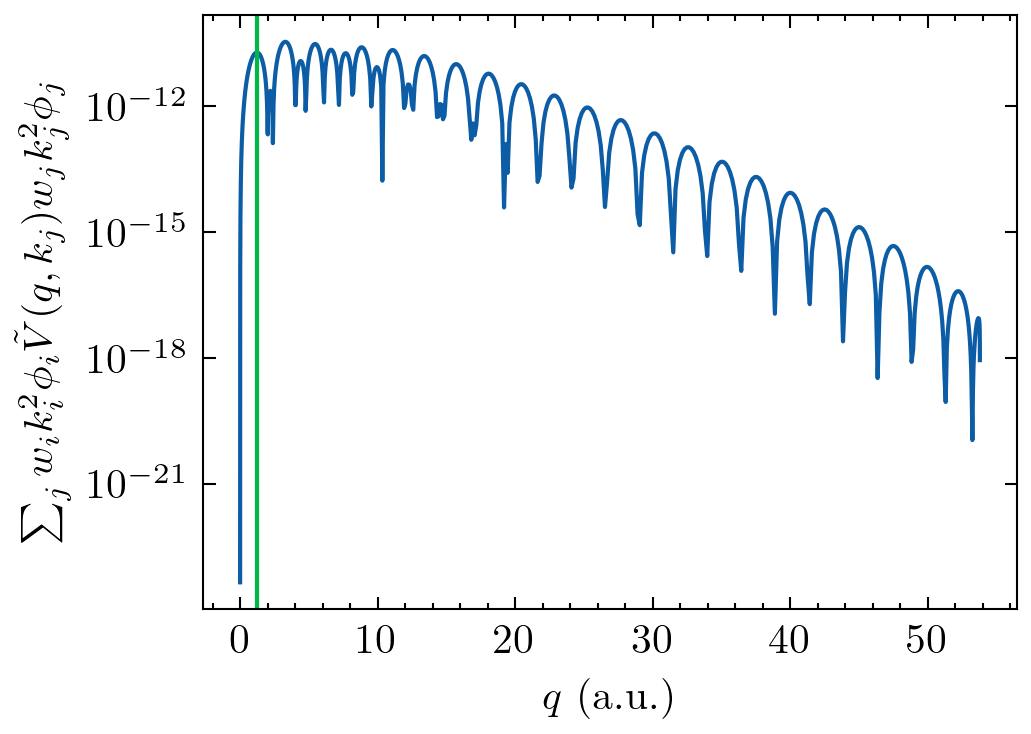

In [83]:
state = 0

phi_q = normalization_constant(evecs[:, state], ls.q, ls.wq)*evecs[:, state]

fig, ax = plt.subplots(dpi=300)
fig.patch.set_facecolor('white')

# ax.plot(ls.q, phi_q)
ax.plot(ls.q, np.abs(ls.wq * ls.q**2 * phi_q * (ls.counterterm.gen(1, 0) @ (ls.wq * ls.q**2 * phi_q))))
ax.axvline(1/ls.r_c, color='C1')

ax.set_ylabel(r'$\sum_j w_i k_i^2 \phi_i \tilde{V}(q, k_j) w_j k_j^2 \phi_j$')
ax.set_xlabel(r'$q$ (a.u.)');
ax.set_yscale('log');

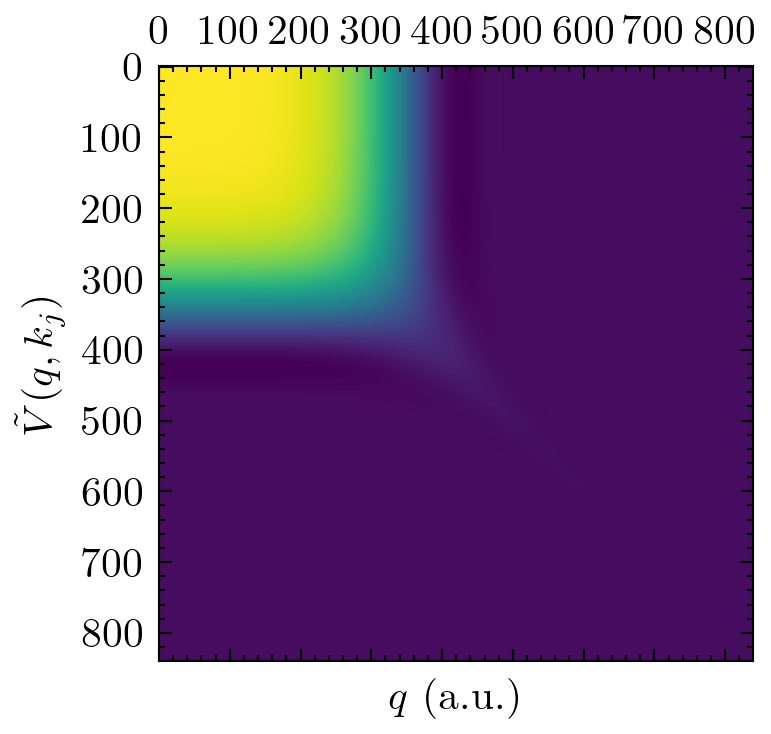

In [81]:
fig, ax = plt.subplots(dpi=300)
fig.patch.set_facecolor('white')

ax.matshow(ls.counterterm.gen(1, 0))

ax.set_ylabel(r'$\tilde{V}(q, k_j)$')
ax.set_xlabel(r'$q$ (a.u.)');
# ax.set_yscale('log');

In [9]:
guess = np.array([-0.05, 0.09])
f_root(guess, ls)

array([-0.36721285,  0.15317638])

In [10]:
class Spectrum:
    def __init__(self, ls, glo, gnlo):
        evals, evecs = bind.bound_states(ls.v_tilde, ls.counterterm.gen(glo, 0), 1, ls.q, ls.wq)
        self.lo_evals = np.copy(evals)
        self.lo_evecs = np.copy(evecs)
        self.R = ls.r_c
        self.glo = glo
        self.g_nlo = gnlo
        
        self.overlap = M(ls, self.lo_evals, self.lo_evecs)
        self.nlo_evals = self.lo_evals + self.g_nlo*self.lo_evals*self.overlap

In [11]:
optimize.fsolve(f_root, guess, args=(ls))

array([-0.05066864,  0.37794541])

In [12]:
systems = []
for i in tqdm(range(Rs.size)):
    Ri = Rs[i]
    qmax = f*2/Ri
    systems.append(
        LocalSystem(Ri, qmesh=(*utility.log_mesh(0, qmax, nq), qmax))
    )

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [07:43<00:00,  9.26s/it]


In [13]:
glos = np.zeros(Rs.size)
gnlos = np.zeros(Rs.size)
specs = []

for (i, (Ri, gi)) in enumerate(zip(Rs, gs)):
    qmax = f*2/Ri
    ls = systems[i]
    
    result = optimize.fsolve(f_root, guess, args=(ls), xtol=1e-10)
    glo, gnlo = result
    
    glos[i] = glo
    gnlos[i] = gnlo
    specs.append(Spectrum(ls, glo, gnlo))
    
    print(f'i = {i}  R = {Ri:.4e}  g_lo = {glo:.4e}  g_nlo = {gnlo:.4e}')
    if i == Rs.size-1:
        break
    
    if i < 5:
        guess = result
    else:
        glo_curve = interp1d(Rs[i-5:i], glos[i-5:i], kind='cubic', fill_value='extrapolate')
        gnlo_curve = interp1d(Rs[i-5:i], gnlos[i-5:i], kind='cubic', fill_value='extrapolate')
        try:
            guess = np.array([glo_curve(Rs[i+1]), gnlo_curve(Rs[i+1])])
        except:
            print('Did not get a good guess.')
            break

i = 0  R = 3.2710e+00  g_lo = -5.0669e-02  g_nlo = 3.7795e-01
i = 1  R = 3.0823e+00  g_lo = -5.3955e-02  g_nlo = 4.2982e-01
i = 2  R = 2.9142e+00  g_lo = -5.6586e-02  g_nlo = 3.0929e-01
i = 3  R = 2.7634e+00  g_lo = -5.8496e-02  g_nlo = 1.3431e-01
i = 4  R = 2.6275e+00  g_lo = -5.9890e-02  g_nlo = 4.8662e-02
i = 5  R = 2.5044e+00  g_lo = -6.0957e-02  g_nlo = 5.5870e-02
i = 6  R = 2.3922e+00  g_lo = -6.1665e-02  g_nlo = 7.6029e-02
i = 7  R = 2.2897e+00  g_lo = -6.1848e-02  g_nlo = 5.8537e-02
i = 8  R = 2.1956e+00  g_lo = -6.1367e-02  g_nlo = 1.3277e-03
i = 9  R = 2.1089e+00  g_lo = -6.0187e-02  g_nlo = -6.6665e-02
i = 10  R = 2.0288e+00  g_lo = -5.8361e-02  g_nlo = -1.1949e-01
i = 11  R = 1.9546e+00  g_lo = -5.5942e-02  g_nlo = -1.5387e-01
i = 12  R = 1.8856e+00  g_lo = -5.2941e-02  g_nlo = -1.7980e-01
i = 13  R = 1.8213e+00  g_lo = -4.9351e-02  g_nlo = -2.0389e-01
i = 14  R = 1.7613e+00  g_lo = -4.5183e-02  g_nlo = -2.2444e-01
i = 15  R = 1.7051e+00  g_lo = -4.0479e-02  g_nlo = -2.3566

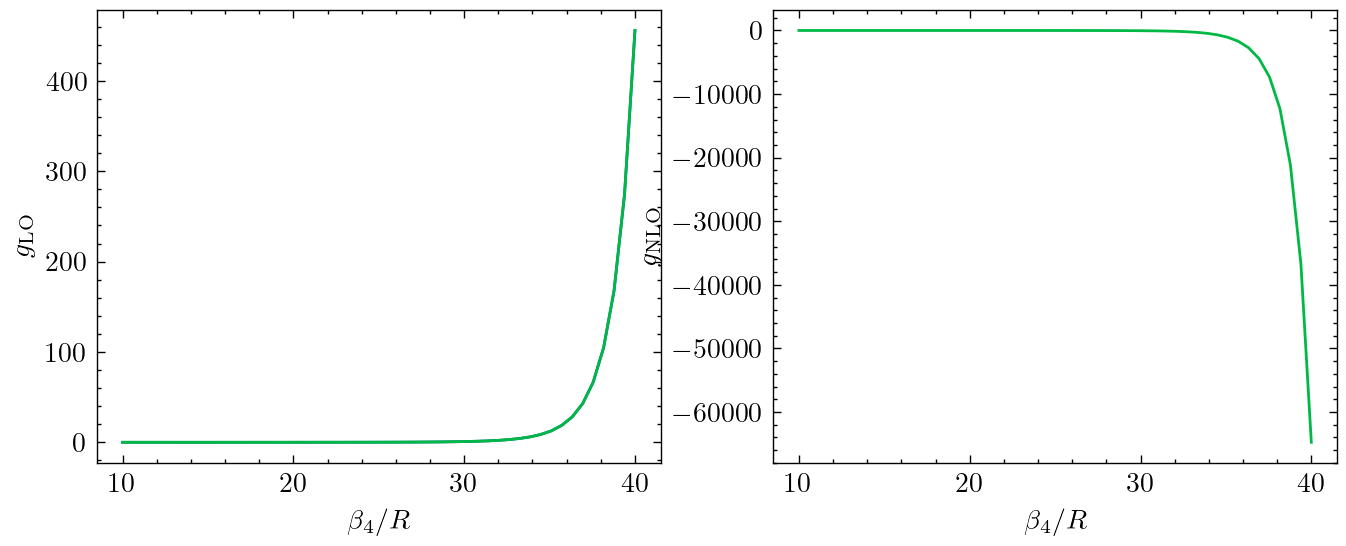

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(2*gr*h, h), dpi=200)
fig.patch.set_facecolor('white')

ax[0].plot(const.BETA4/Rs, glos)
ax[0].plot(const.BETA4/Rs, gs)
ax[1].plot(const.BETA4/Rs, gnlos, color='C1')

# ax.set_ylim([-1, 1])
ax[0].set_xlabel(r'$\beta_4/R$')
ax[0].set_ylabel(r'$g_{\rm LO}$')
ax[1].set_xlabel(r'$\beta_4/R$')
ax[1].set_ylabel(r'$g_{\rm NLO}$');

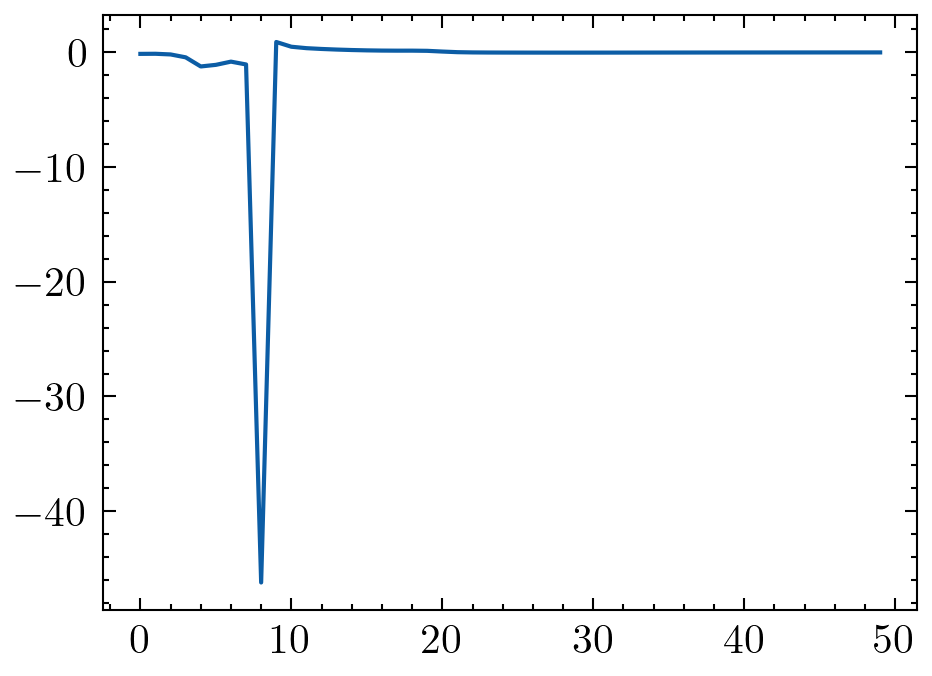

In [15]:
fig, ax = plt.subplots(dpi=300)
fig.patch.set_facecolor('white')\

ax.plot(glos/gnlos);

In [16]:
np.savetxt('rgflow_local_nlo_a0_B6_fix_hp.txt', np.vstack((Rs, glos, gnlos)).T, header='R  g_LO  g_NLO')

In [17]:
rgf_old = np.loadtxt('rgflow_local_nlo_a0_B6_fix.txt')

In [18]:
gnlos / rgf_old[:, 2]

array([ 3.36027807,  3.73013427,  4.11767997,  4.48609259,  4.87597399,
        5.10611476,  5.30716817,  5.64141424, -6.53738838,  5.66147914,
        5.95407189,  6.12934897,  6.2737676 ,  6.35121874,  6.40499744,
        6.38117519,  6.283471  ,  6.04792569,  5.5885053 ,  4.93202051,
        4.12398206,  3.23044836,  2.3831112 ,  1.70349305,  1.24145553,
        0.98295829,  0.83844206,  0.74330214,  0.68074744,  0.63047935,
        0.59845642,  0.56219227,  0.53575328,  0.51944274,  0.50316247,
        0.48385673,  0.47339201,  0.46322232,  0.4533942 ,  0.44660118,
        0.44292331,  0.4336184 ,  0.43215537,  0.42465035,  0.42271021,
        0.41894167,  0.41398763,  0.41129253,  0.40665121,  0.40702965])

In [19]:
lo_results = np.loadtxt('spectra_local_lo_a0_fix_hp.txt')

In [20]:
# lo_specs = np.array([spec.lo_evals for spec in specs])
nlo_specs = np.array([spec.nlo_evals for spec in specs])

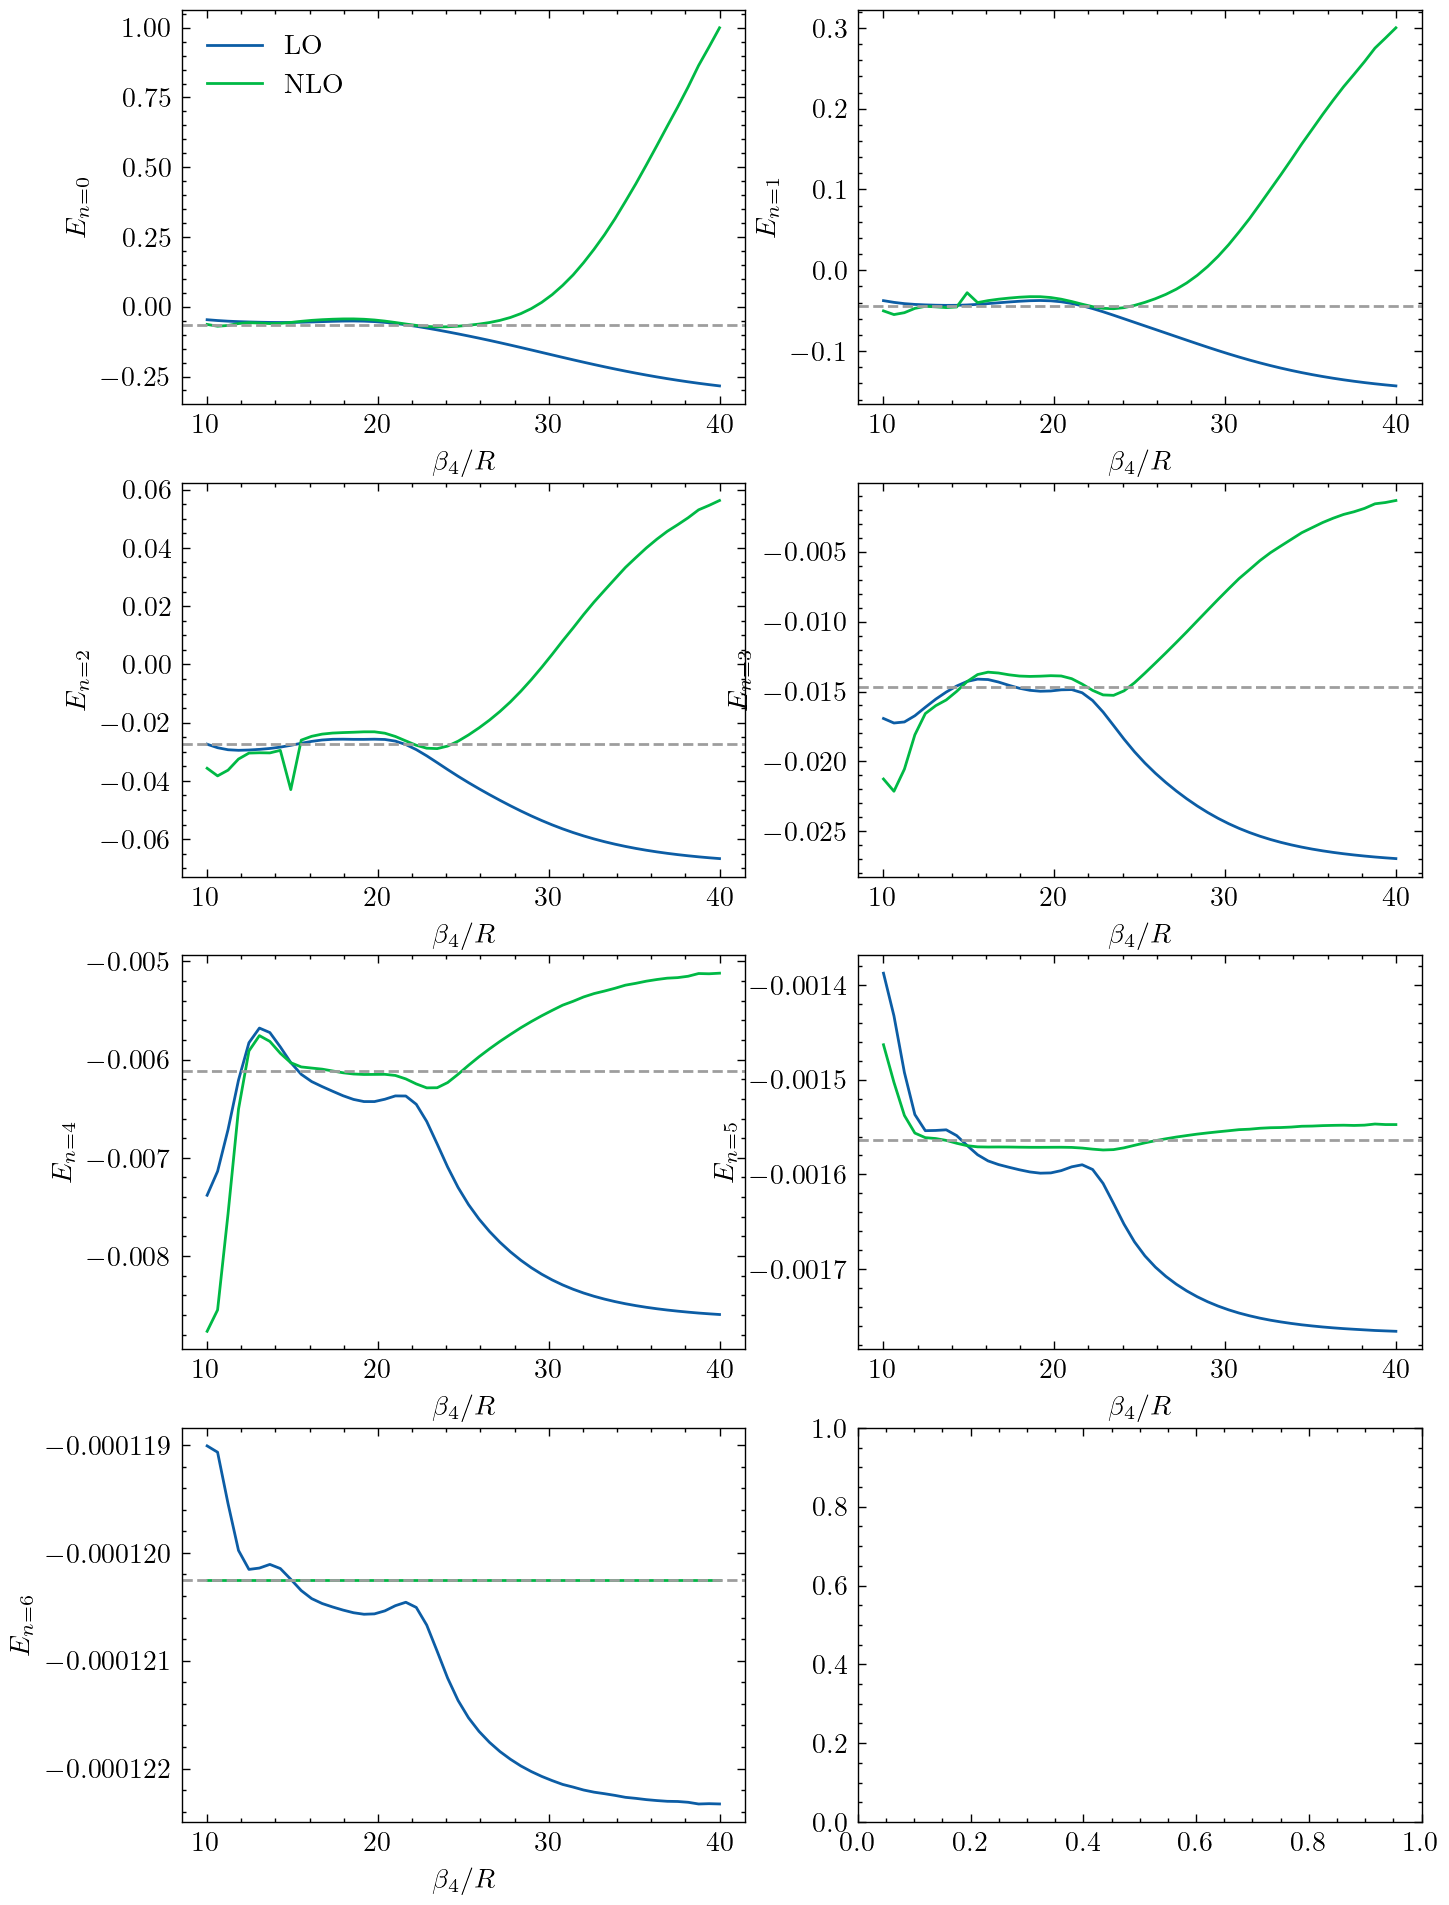

In [21]:
fig, ax = plt.subplots(4, 2, figsize=(2*gr*h, 4*h), dpi=200)
fig.patch.set_facecolor('white')

for i in range(7):
    ax[i//2, i%2].plot(const.BETA4/lo_results[:, 0], lo_results[:, i+1], label=r'LO')
    ax[i//2, i%2].plot(const.BETA4/Rs, nlo_specs[:, i], label=r'NLO')
    ax[i//2, i%2].axhline(mm_evals[i], linestyle='--', color='C6')
    ax[i//2, i%2].set_xlabel(r'$\beta_4/R$')
    ax[i//2, i%2].set_ylabel(r'$E_{n=%d}$' % (i))
    if i == 0:
        ax[0, 0].legend()

In [22]:
all_overlaps = np.array([spec.overlap for spec in specs])

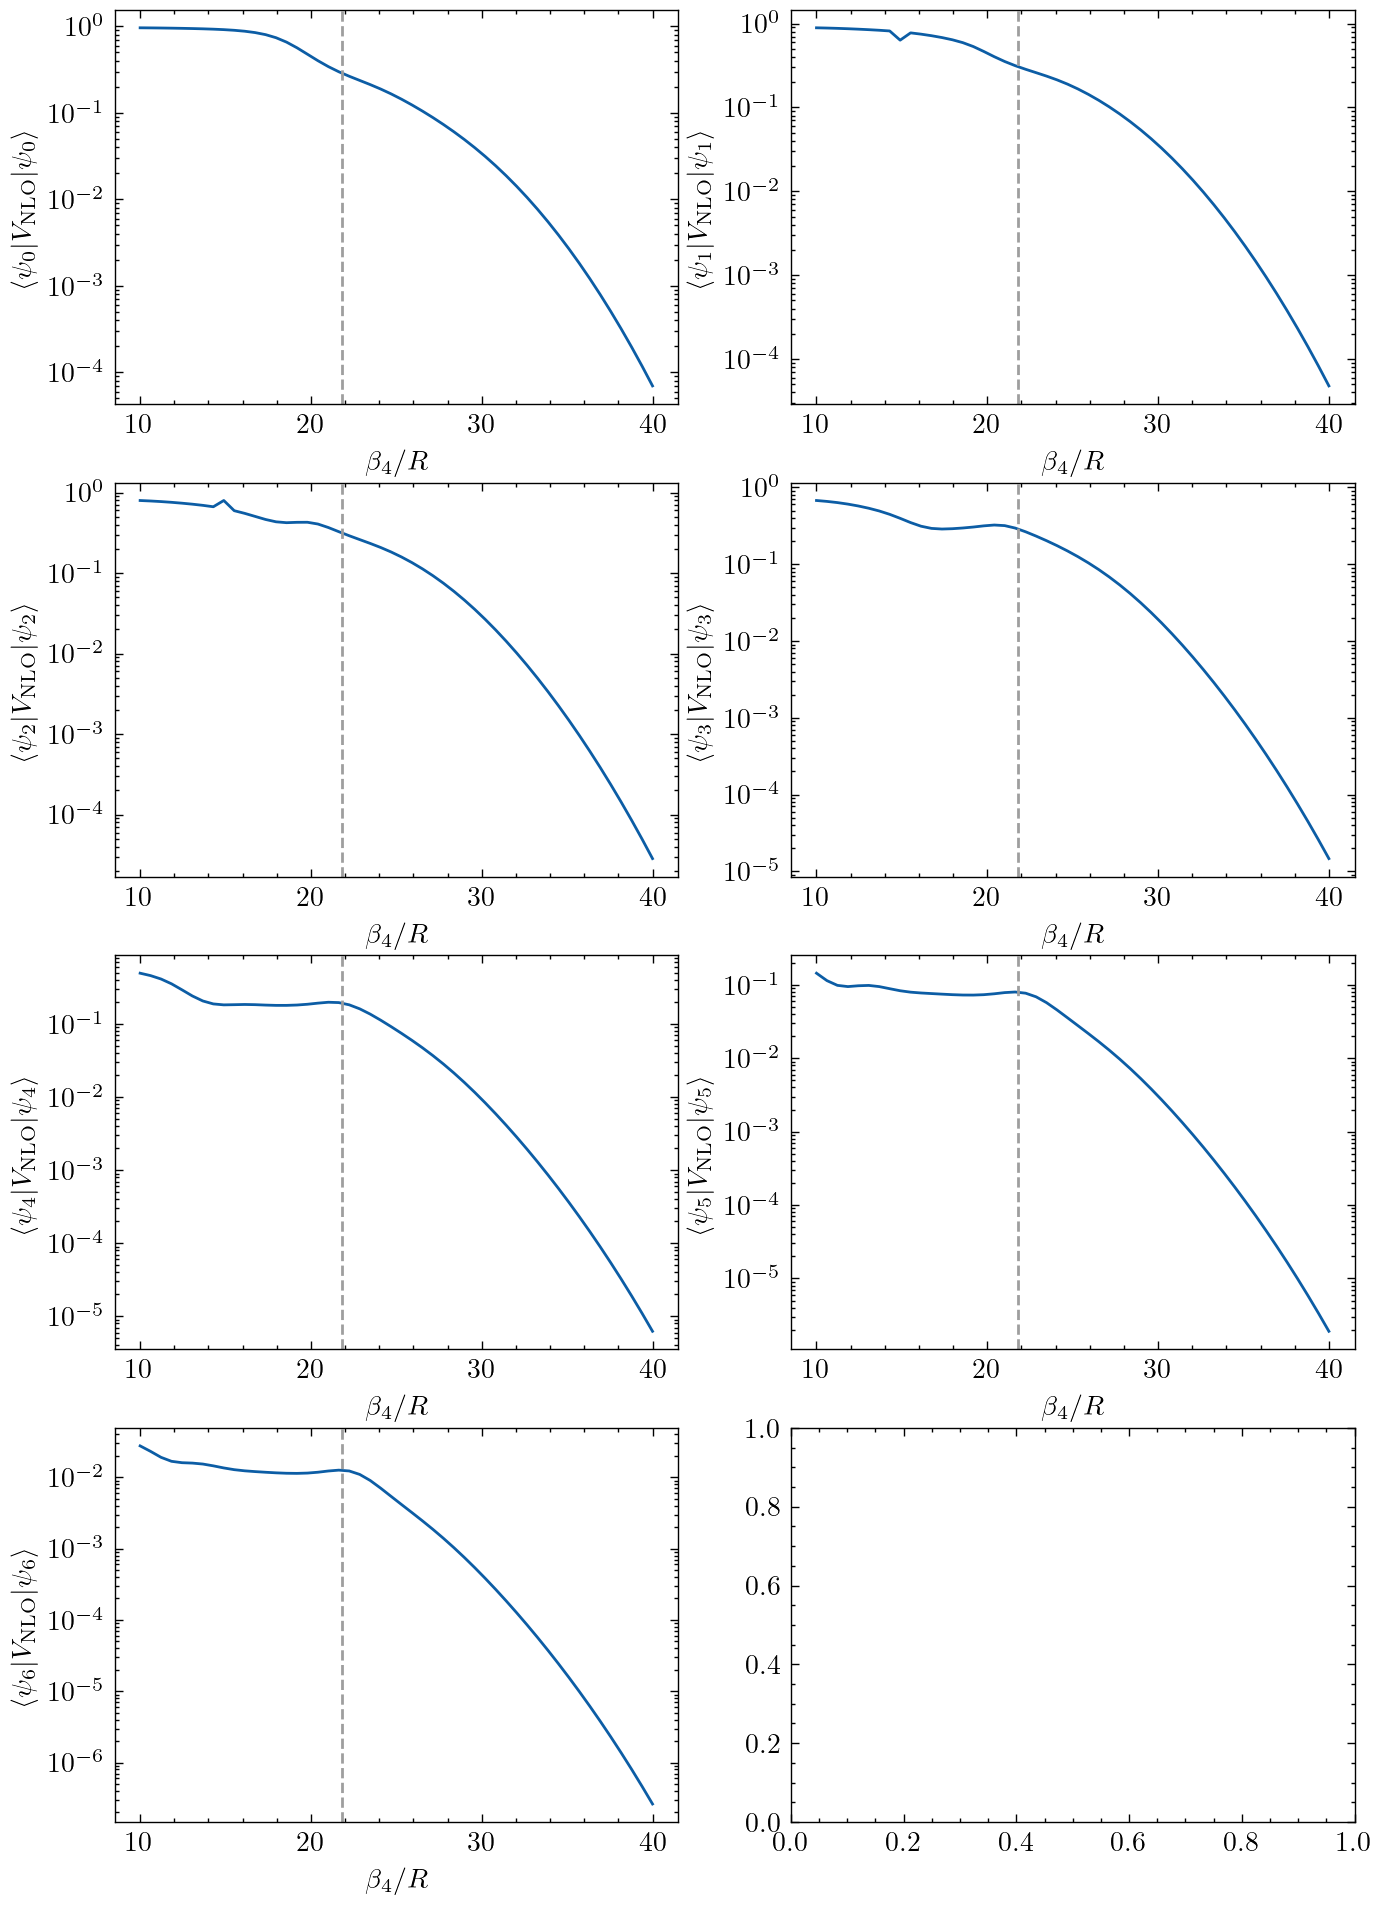

In [31]:
fig, ax = plt.subplots(4, 2, figsize=(2*gr*h, 4*h), dpi=200)
fig.patch.set_facecolor('white')

x = const.BETA4/Rs

for i in range(7):
    ax[i//2, i%2].plot(x, all_overlaps[:, i])
    ax[i//2, i%2].set_xlabel(r'$\beta_4/R$')
    ax[i//2, i%2].set_ylabel(r'$\langle\psi_{%d}|V_{\rm NLO}|\psi_{%d}\rangle$' % (i, i))
    ax[i//2, i%2].axvline(const.BETA4/1.5, linestyle='--', color='C6')
    ax[i//2, i%2].set_yscale('log')

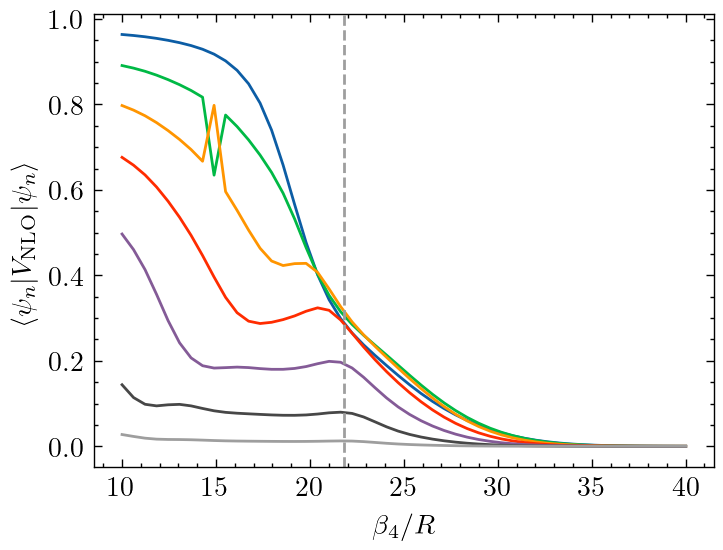

In [24]:
fig, ax = plt.subplots(figsize=(gr*h, h), dpi=200)
fig.patch.set_facecolor('white')

for i in range(7):
    ax.plot(const.BETA4/Rs, all_overlaps[:, i])
ax.set_xlabel(r'$\beta_4/R$')
ax.set_ylabel(r'$\langle\psi_{n}|V_{\rm NLO}|\psi_{n}\rangle$')
ax.axvline(const.BETA4/1.5, linestyle='--', color='C6')

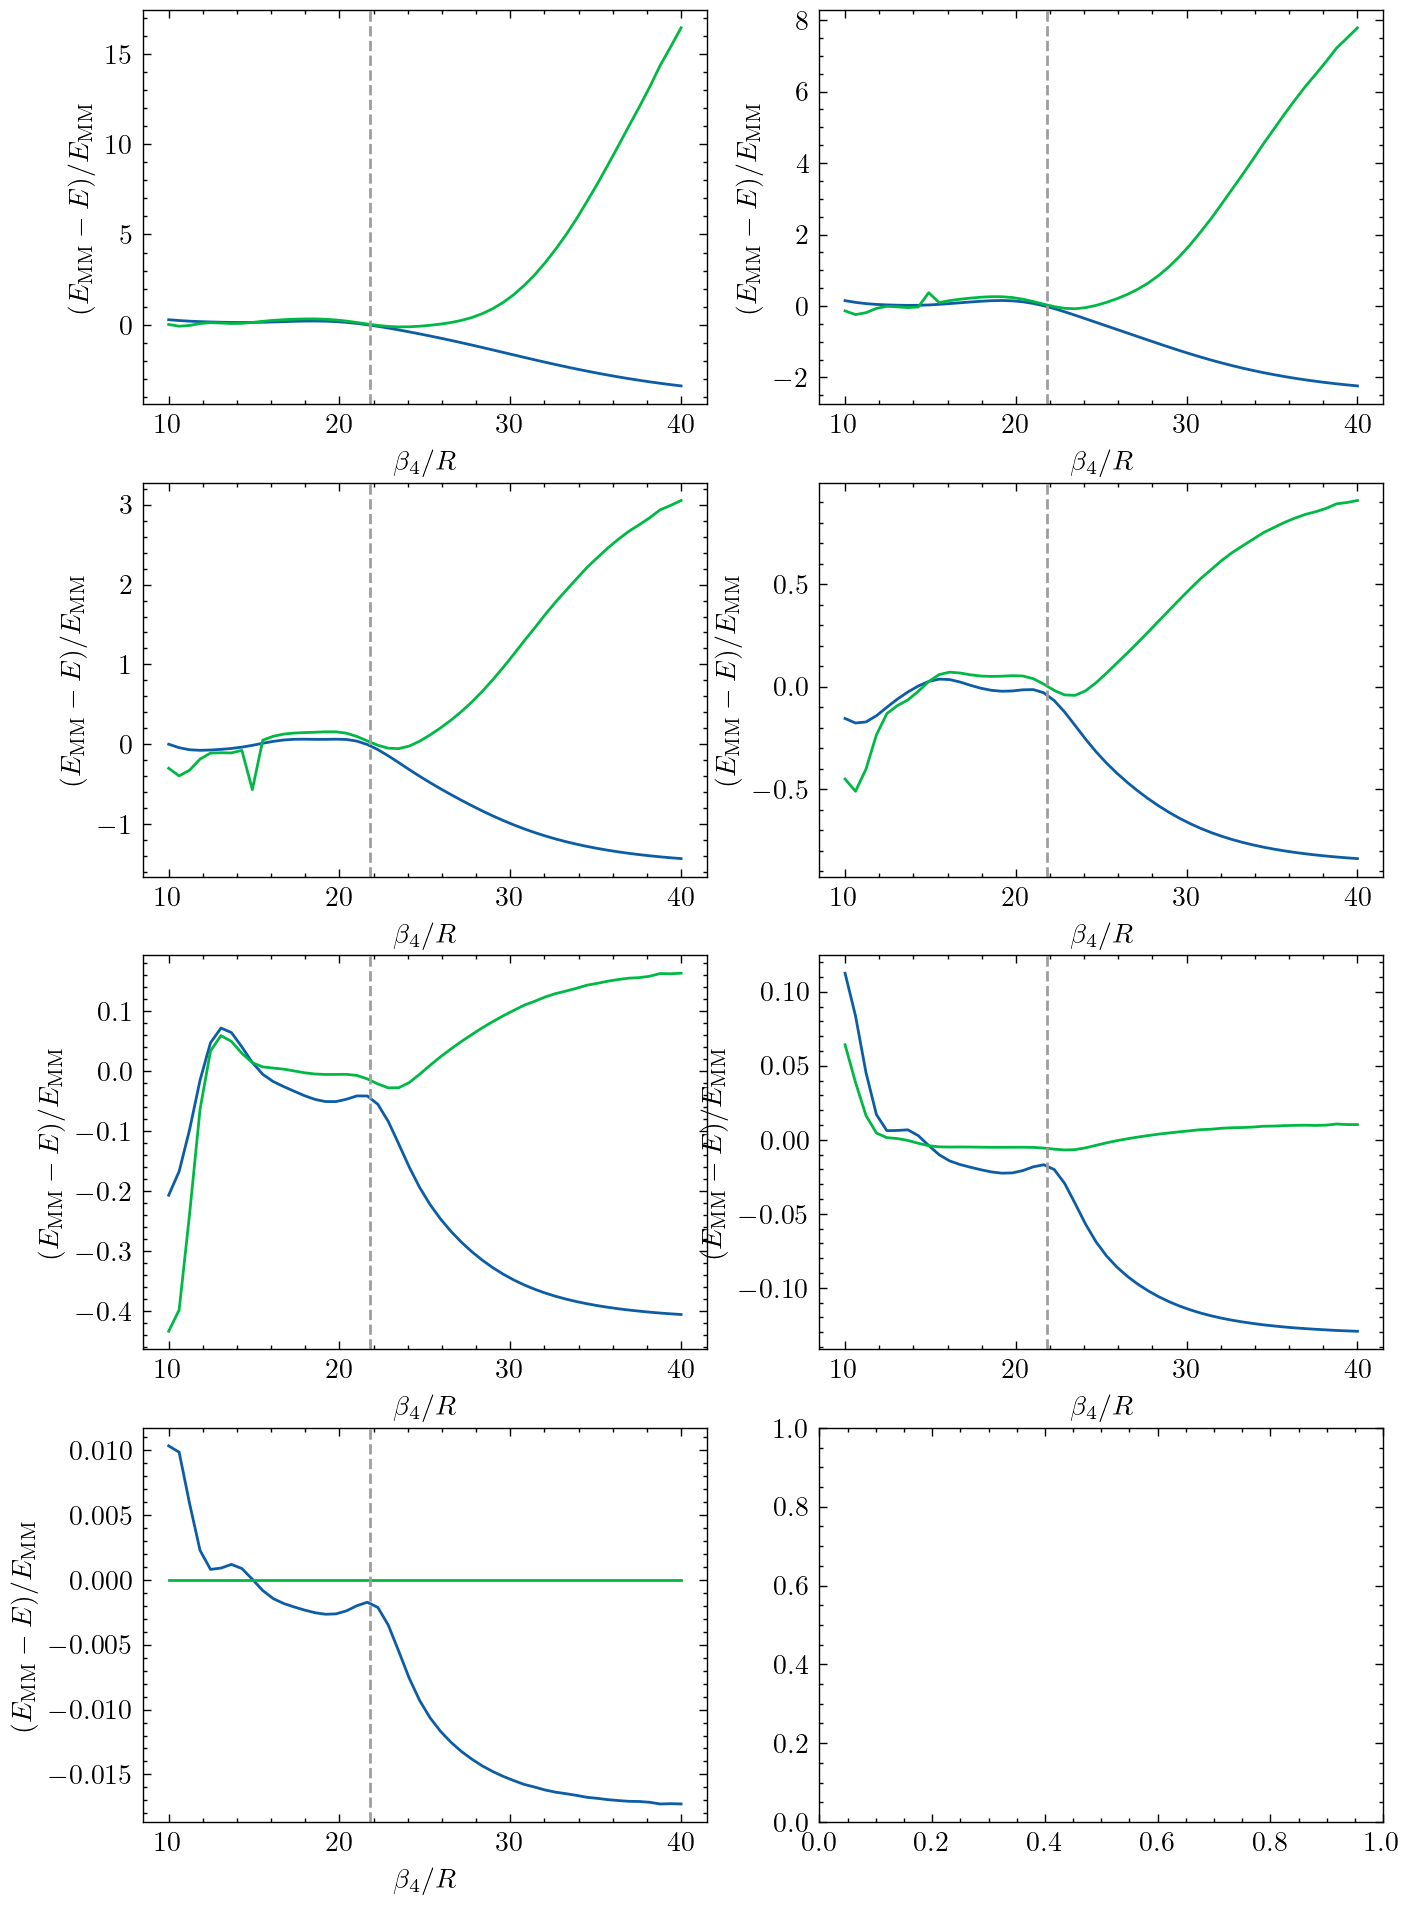

In [25]:
fig, ax = plt.subplots(4, 2, figsize=(2*gr*h, 4*h), dpi=200)
fig.patch.set_facecolor('white')

for i in range(7):
    ax[i//2, i%2].plot(const.BETA4/lo_results[:, 0], (mm_evals[i] - lo_results[:, i+1])/mm_evals[i])
    ax[i//2, i%2].plot(const.BETA4/Rs, (mm_evals[i] - nlo_specs[:, i])/mm_evals[i])
    ax[i//2, i%2].set_xlabel(r'$\beta_4/R$')
    ax[i//2, i%2].set_ylabel(r'$(E_{\rm MM}-E)/E_{\rm MM}$')
    ax[i//2, i%2].axvline(const.BETA4/1.5, linestyle='--', color='C6')

In [40]:
index = 49
sys = systems[index]
spec = specs[index]
psi_Vnlo_psi(spec.lo_evals, spec.lo_evecs, sys.r_c), M(sys, spec.lo_evals, spec.lo_evecs)

(array([1.21060353e-05, 6.50271085e-06, 4.73726093e-06, 2.89778784e-06,
        1.67179083e-06, 8.93390784e-07, 2.22502226e-07]),
 array([6.98743518e-05, 4.78110309e-05, 2.84708955e-05, 1.46652194e-05,
        6.24471114e-06, 1.90892767e-06, 2.62643004e-07]))

In [38]:
spec.overlap

array([6.98743518e-05, 4.78110309e-05, 2.84708955e-05, 1.46652194e-05,
       6.24471114e-06, 1.90892767e-06, 2.62643004e-07])

In [29]:
ls.r_c

0.8177473216915315

In [30]:
specs[-1].overlap

array([6.98743518e-05, 4.78110309e-05, 2.84708955e-05, 1.46652194e-05,
       6.24471114e-06, 1.90892767e-06, 2.62643004e-07])

In [28]:
M(ls, evals, evecs)

array([0.7435279 , 0.68743928, 0.6824243 , 0.64185256, 0.56935285,
       0.33473437, 0.11476502])

In [32]:
np.savetxt('spectra_local_nlo_a0_B6_fix_hp.txt', np.vstack((Rs, nlo_specs.T)).T,
           header ='R  E_0  E_1  E_2  E_3  E_4  E_5  E_6')

In [33]:
np.savetxt('spectra_Mott_Massey_hp.txt', mm_evals)